# Model Comparison

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

Text(0.5, 1.0, 'Scatter plot')

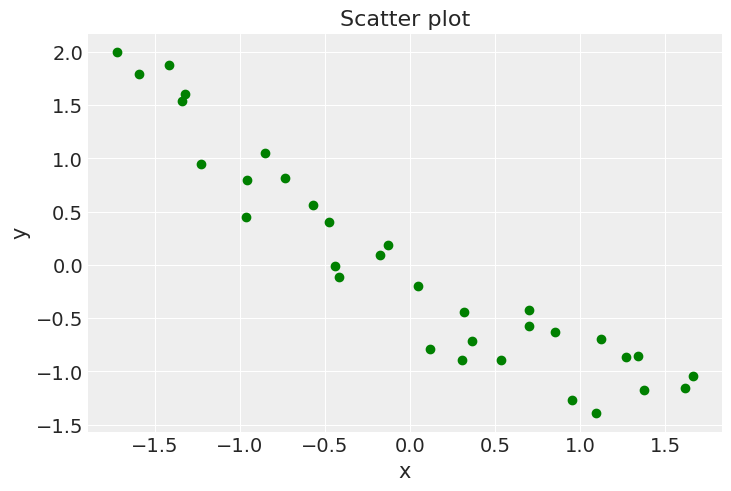

In [8]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
    x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s, color= 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot')
# plt.savefig('B11197_05_01.png', dpi=300)

In [10]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_l = pm.sample(2000, cores=2)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    trace_p = pm.sample(2000, cores=2)

/tmp/ipykernel_9261/1959961075.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_l = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
/tmp/ipykernel_9261/1959961075.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_p = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


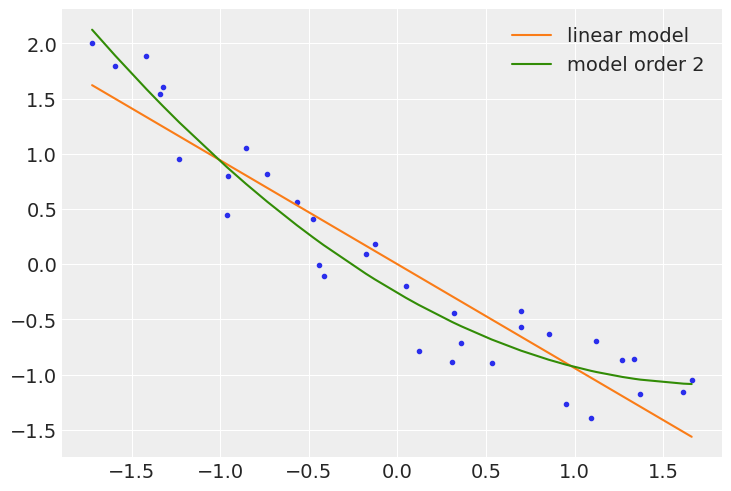

In [7]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new
plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)
plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

# α_p_post = trace_p['α'].mean()
# β_p_post = trace_p['β'].mean(axis=0)
# x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
# y_p_post = α_p_post + np.dot(β_p_post, x_new_p)

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()
# plt.savefig('B11197_05_02.png', dpi=300)

## Posterior predictive checks

In [19]:
y_l = pm.sample_posterior_predictive(trace_l, 2000, model=model_l)['y_pred']

y_p = pm.sample_posterior_predictive(trace_p, 2000, model=model_p)['y_pred']

/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


([], [])

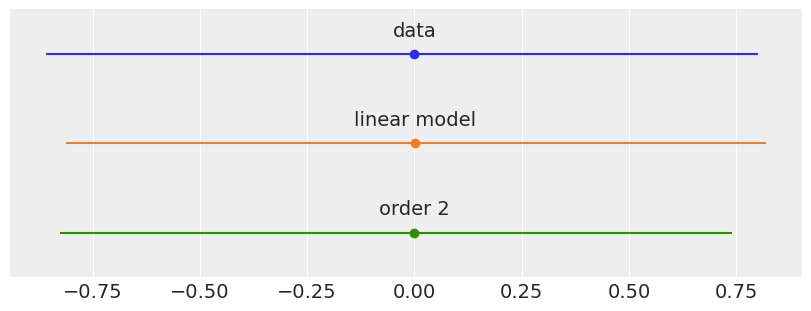

In [9]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
# plt.savefig('B11197_05_03.png', dpi=300)

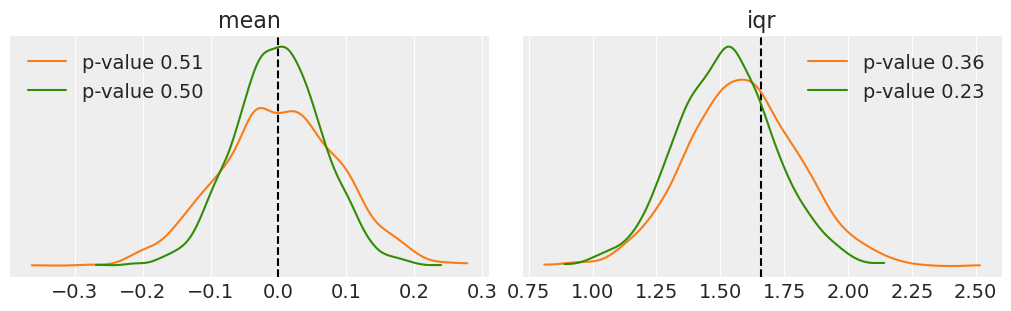

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])

    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
# plt.savefig('B11197_05_04.png', dpi=300)

# Occam's razor – simplicity and accuracy 

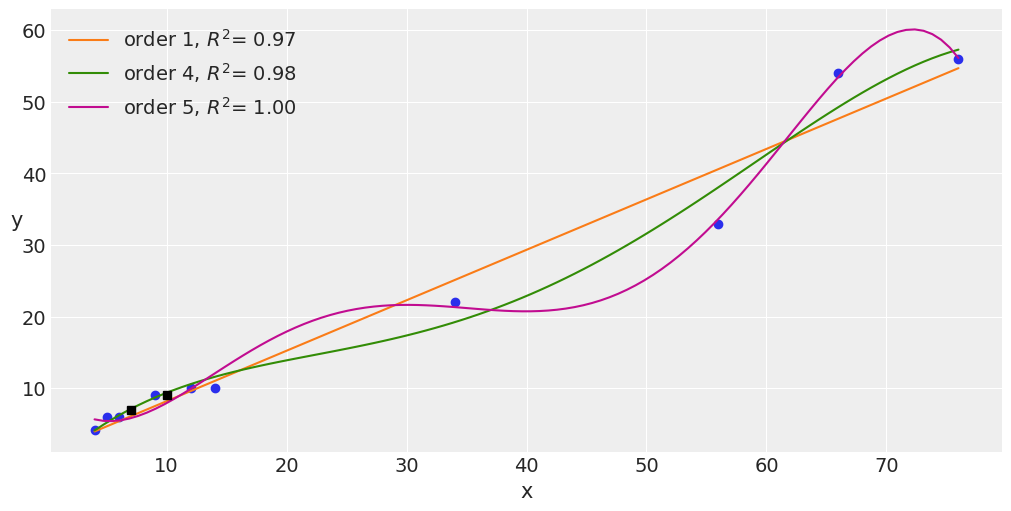

In [11]:
x = np.array([4., 5., 6., 9., 12, 14., 34., 56., 66.,76.])
y = np.array([4.2, 6., 6., 9., 10, 10., 22., 33.,54., 56.])

plt.figure(figsize=(10, 5))
order = [ 1, 4, 5]
plt.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
# plt.savefig('B11197_05_05.png', dpi=300)
plt.plot([10, 7], [9, 7], 'ks')
# plt.savefig('B11197_05_06.png', dpi=300)

## Computing information criteria with PyMC3

In [11]:
waic_l = az.waic(trace_l)
waic_l

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.34     2.68
p_waic        2.44        -

In [14]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p},  method='BB-pseudo-BMA')
cmp_df

cmp_sf = az.compare({'model_l':trace_l, 'model_p':trace_p},  method='stacking')
cmp_sf

Got error No model on context stack. trying to find log_likelihood in translation.
/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.596147,2.676267,0.000000,1.000000e+00,2.335643,0.000000,False,log
model_l,1,-14.364429,2.461980,9.768281,1.421085e-13,2.685935,2.668578,False,log


<AxesSubplot:xlabel='Log'>

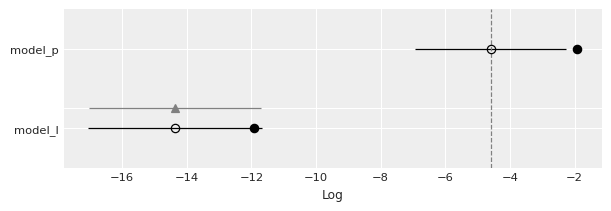

In [15]:
az.plot_compare(cmp_sf)
# plt.savefig('B11197_05_08.png', dpi=300)

## Model Averaging

In [17]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p],
                                        samples=1000,
                                        models=[model_l, model_p],
                                        weights=[w, 1-w])

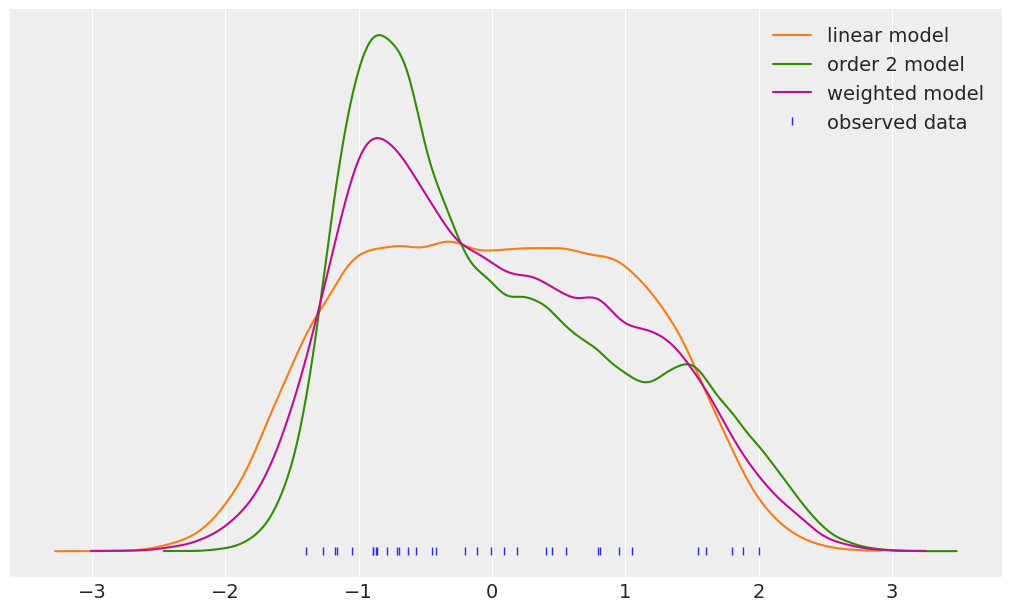

In [20]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color': 'C1'}, label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color': 'C2'}, label='order 2 model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
           label='weighted model', ax=ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks([])
plt.legend()
# plt.savefig('B11197_05_09.png', dpi=300)

El modelo cuadratico es mejor, porque su KDE tiene menos WAIC que el lineal, y mas valores debajo de <0

# Bayes factors

In [5]:
coins = 3000 # 300
heads = 1300 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

/tmp/ipykernel_9513/2685801681.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_BF = pm.sample(5000, cores=2)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

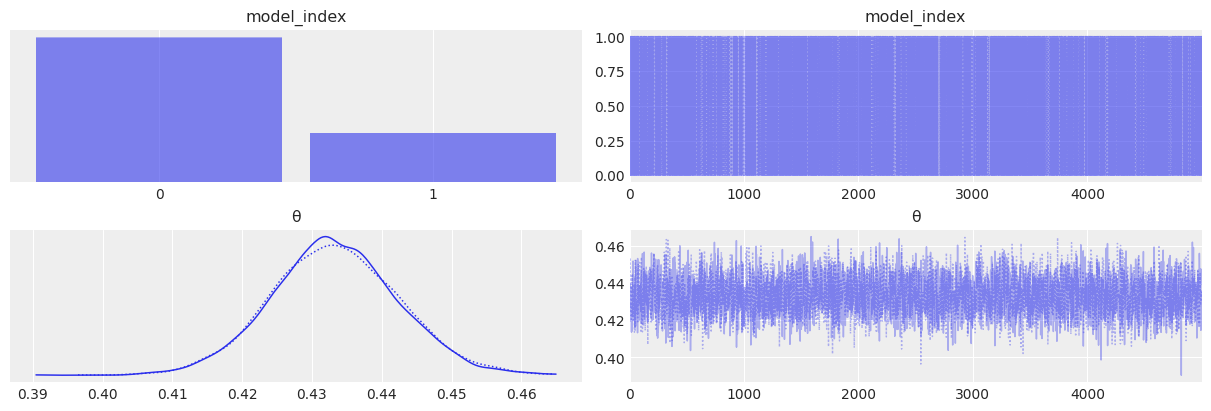

In [6]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)

    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    # a priori
    θ = pm.Beta('θ', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF = pm.sample(5000, cores=2)
az.plot_trace(trace_BF)
# plt.savefig('B11197_05_11.png', dpi=300)

In [8]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0]) # el último término es 1
BF

1.0

In [15]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample_smc(2500,  cores=2)

with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample_smc(2500, cores=2)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.113
Stage:   2 Beta: 0.848
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.014
Stage:   1 Beta: 0.111
Stage:   2 Beta: 0.830
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.024
Stage:   2 Beta: 0.149
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.023
Stage:   2 Beta: 0.149
Stage:   3 Beta: 1.000


In [29]:
model_BF_

## Bayes factors and information criteria

In [7]:
traces = []
waics = []

for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            trace = pm.sample(2000, cores =2)
            traces.append(trace)
            waics.append(az.waic(trace))

/tmp/ipykernel_8300/604592864.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, cores =2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.
/tmp/ipykernel_8300/604592864.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, cores =2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
/tmp/ipykernel_8300/604592864.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, cores =2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
/tmp/ipykernel_8300/604592864.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, cores =2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

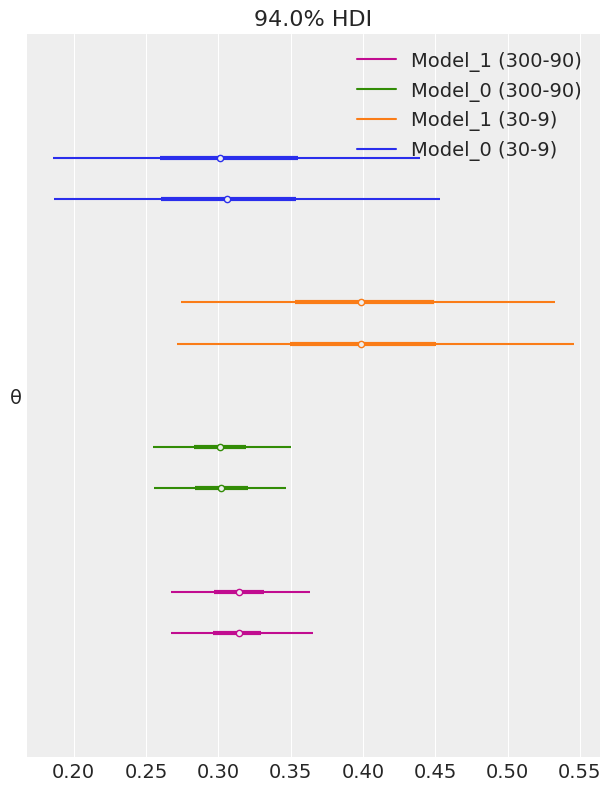

In [5]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

az.plot_forest(traces, model_names=model_names)
# plt.savefig('B11197_05_12.png', dpi=300)

Text(0.5, 0, 'Deviance')

/home/dani/anaconda3/envs/fb/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


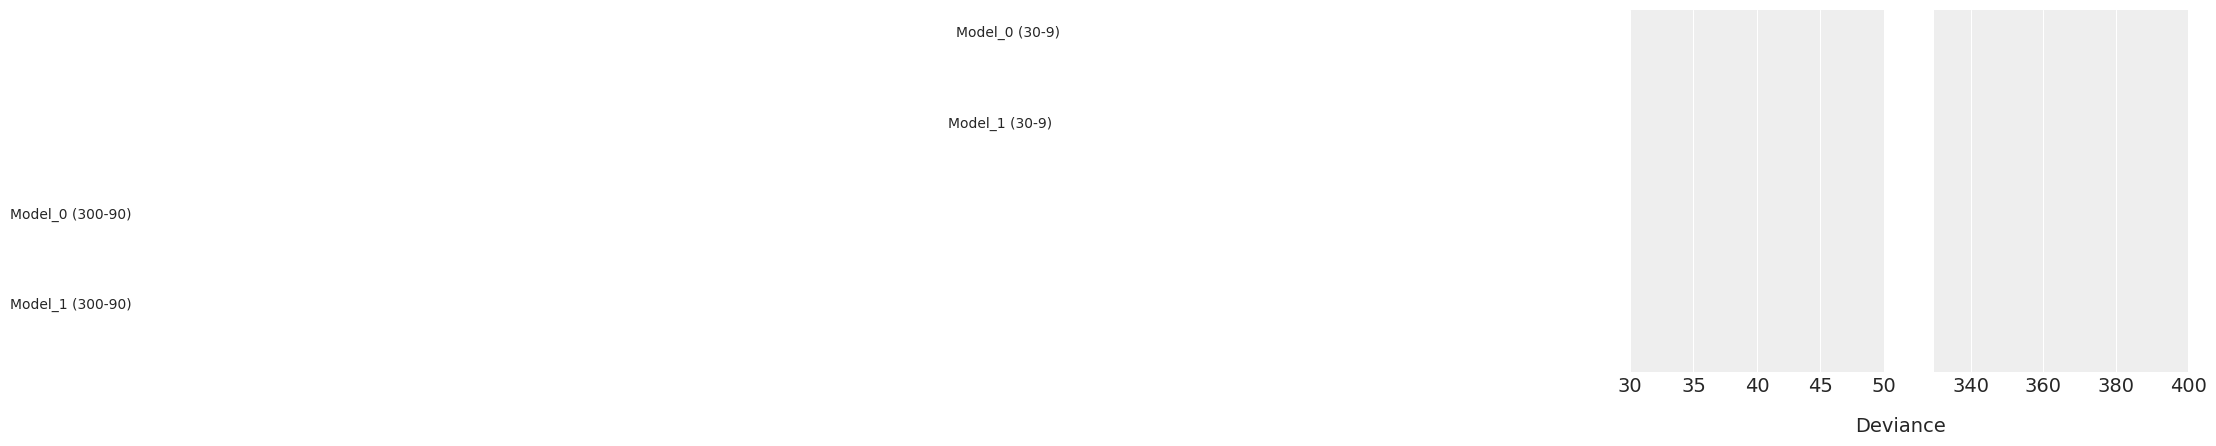

In [9]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')

ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
# plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14)
# plt.savefig('B11197_05_13.png', dpi=300)

## Regularizing priors

(-7.0, 7.0)

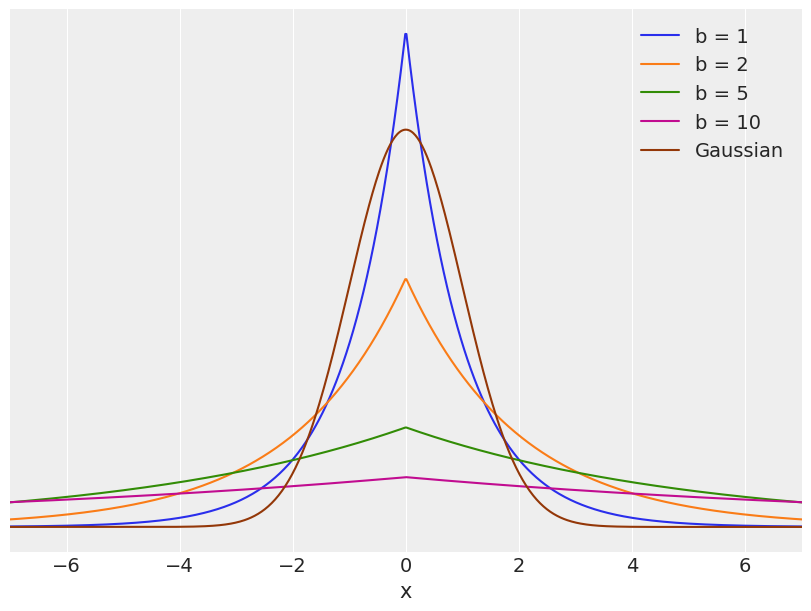

In [10]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 1000)
for df in [1, 2, 5, 10]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f'b = {df}')

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-7, 7)
# plt.savefig('B11197_05_14.png', dpi=300)

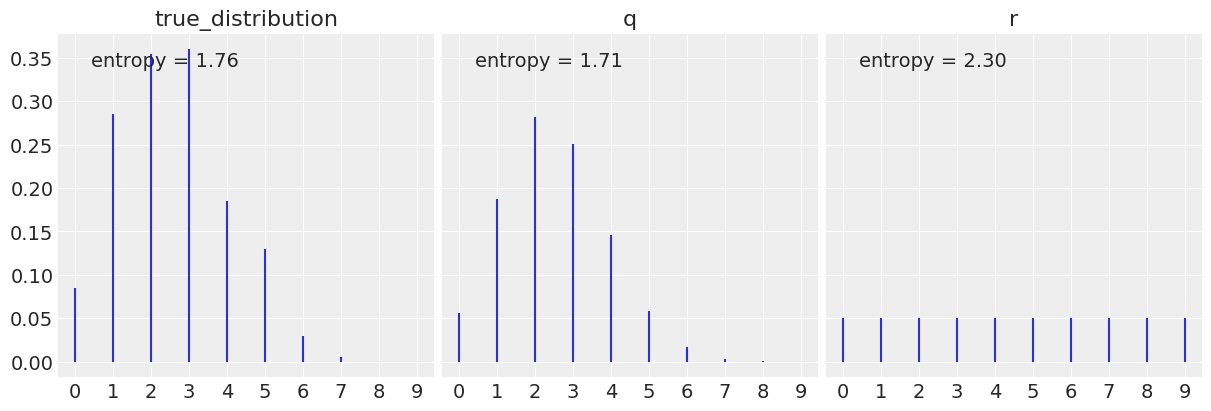

In [14]:
# np.random.seed(912)
x = range(0, 10)
q = stats.binom(10, 0.25)
r = stats.randint(0, 20)

true_distribution = [list(q.rvs(300)).count(i) / 200 for i in x]

q_pmf = q.pmf(x)
r_pmf = r.pmf(x)

_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label=f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

# plt.savefig('B11197_05_15.png', dpi=300)

In [15]:
stats.entropy(true_distribution, q_pmf), stats.entropy(true_distribution, r_pmf)

(0.012230902095666032, 0.5394576177444508)

In [16]:
stats.entropy(r_pmf, q_pmf), stats.entropy(q_pmf, r_pmf)

(1.7162776968515678, 0.5881765673403214)